# Modeling Credit Risk with Lending Club data

Internal name: KP102


## Outline

1. Business problem and summary of results
2. Data import.
3. Data preprocessing.
4. EDA.
5. Sample split, missing values and feature engineering.
6. Modeling.
7. Interpretation of the results.
8. Business implications.



### 1. Business problem

Lending Club was a peer to peer lending platform. Over 2007-2020 it issued at least 2.9M loans. Loans varied in size between \\$1,000 and \\$40,000 and were used to refinance consumer loans or to cover midsize expenses.

After accepting an application for a loan, Lending Club used internal risk model to assign credit rating and an interest rate to a loan. Then it placed the loan on online platform, where investors could invest in it. Investors fully bore credit risk in return for getting interest payments. 

Thus the key problem of investors in Lending Club was to determine riskiness of a loan. Investors' objective is to avoid risky loans, in which interest rate is not enough to cover expected credit loss. While Lending Club no longer engages in peer to peer lending, there is a number of P2P lending platforms, operating right now. The goal of this project is to solve investors' problem by building ML model.


#### Objective: Predict delinquency of a loan borrower.


#### Metric: Precision at 10% Recall.


#### Summary of Results
​
**I build XGBoost model to predict loan delinquencies. The model has 60.3% precision at 10% recall. It allows Lending Club investors to save \\$59.7M by avoiding the riskiest loans. The savings come from allocating investment funds into risk-free bonds instead of the riskiest loans.** 


##### Notes:

One big question about this data is which features are available at the origination time and are never updated afterwards. It seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

I will use only features, known before loan issuance.

### 2. Data import

To make analysis manageable, I use 30% sample of the original dataset with 2.9M loans. This is a random sample. If you ramdomly sample original data and use this code, you should get very similar results.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys, re
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [2]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [3]:
time0 = time.time()

with open('/home/jupyter/projects_data/loans/LCLoans_141_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

In [4]:
features_tokeep = ['id', 'loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'recoveries', 'total_rec_prncp', 'total_rec_int']

df = df[features_tokeep]
gc.collect()

recoveries = df[df.loan_status.isin(['Charged Off', 'Default'])][[
    'id', 'loan_status', 'recoveries', 'loan_amnt', 'int_rate', 'total_rec_prncp', 'total_rec_int']]

df.drop(columns = ['recoveries', 'total_rec_prncp', 'total_rec_int'], inplace=True)
# this removes all features, not known to investors ex ante.

df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
    
#df = df.sample(200000, random_state=1)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

(878058, 68)

4.906709671020508

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,1077175,Fully Paid,2400.0,2400.0,2400.0,36.0,15.96,84.330002,2011-12-01,small_business,real estate business,f,Individual,C,C5,739.0,NaN,10+ years,RENT,12252.0,606xx,IL,8.72,Not Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov-2001,2.0,NaN,NaN,2.0,NaN,NaN,10.0,NaN,NaN,2956.0,98.5,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0
1,1071795,Charged Off,5600.0,5600.0,5600.0,60.0,21.28,152.389999,2011-12-01,small_business,Expand Business & Buy Debt Portfolio,f,Individual,F,F2,679.0,NaN,4 years,OWN,40000.0,958xx,CA,5.55,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr-2004,2.0,NaN,NaN,11.0,NaN,NaN,13.0,NaN,NaN,5210.0,32.6,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0
2,1069908,Fully Paid,12000.0,12000.0,12000.0,36.0,12.69,402.540009,2011-12-01,debt_consolidation,Consolidation,f,Individual,B,B5,679.0,UCLA,10+ years,OWN,75000.0,913xx,CA,10.78,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct-1989,0.0,NaN,NaN,12.0,NaN,NaN,34.0,NaN,NaN,23336.0,67.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0
3,1069866,Fully Paid,3000.0,3000.0,3000.0,36.0,9.91,96.680000,2011-12-01,credit_card,citicard fund,f,Individual,B,B1,709.0,Target,3 years,RENT,15000.0,606xx,IL,12.56,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul-2003,2.0,NaN,NaN,11.0,NaN,NaN,11.0,NaN,NaN,7323.0,43.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0
4,1065775,Fully Paid,10000.0,10000.0,10000.0,36.0,15.27,347.980011,2011-12-01,home_improvement,Home,f,Individual,C,C4,674.0,Chin's Restaurant,4 years,RENT,42000.0,921xx,CA,18.60,Not Verified,NaN,61.0,NaN,NaN,NaN,NaN,NaN,Oct-1998,2.0,NaN,NaN,14.0,NaN,NaN,28.0,NaN,NaN,24043.0,70.2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0


### 3. Data preprocessing

I preprocess main features and create a target. To get better separation between repaid and defaulted loans I look only at loans, which are Fully paid, Charged off or in Default.

In [5]:
# remove some very rare loan types:

df = df[~df.purpose.isin(['educational', 'renewable_energy', 'wedding'])]
df.purpose = df.purpose.cat.remove_categories(['educational', 'renewable_energy', 'wedding'])

In [6]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,1077175,Fully Paid,2400.0,2400.0,2400.0,36.0,15.96,84.330002,2011-12-01,small_business,real estate business,f,Individual,C,C5,739.0,NaN,10+ years,RENT,12252.0,606xx,IL,8.72,Not Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-11-01,2.0,NaN,NaN,2.0,NaN,NaN,10.0,NaN,NaN,2956.0,98.5,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,10.080974,0.0
1,1071795,Charged Off,5600.0,5600.0,5600.0,60.0,21.28,152.389999,2011-12-01,small_business,Expand Business & Buy Debt Portfolio,f,Individual,F,F2,679.0,NaN,4 years,OWN,40000.0,958xx,CA,5.55,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-04-01,2.0,NaN,NaN,11.0,NaN,NaN,13.0,NaN,NaN,5210.0,32.6,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,7.666140,0.0
2,1069908,Fully Paid,12000.0,12000.0,12000.0,36.0,12.69,402.540009,2011-12-01,debt_consolidation,Consolidation,f,Individual,B,B5,679.0,UCLA,10+ years,OWN,75000.0,913xx,CA,10.78,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989-10-01,0.0,NaN,NaN,12.0,NaN,NaN,34.0,NaN,NaN,23336.0,67.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,22.166095,0.0
3,1069866,Fully Paid,3000.0,3000.0,3000.0,36.0,9.91,96.680000,2011-12-01,credit_card,citicard fund,f,Individual,B,B1,709.0,Target,3 years,RENT,15000.0,606xx,IL,12.56,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-07-01,2.0,NaN,NaN,11.0,NaN,NaN,11.0,NaN,NaN,7323.0,43.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,8.419064,0.0
4,1065775,Fully Paid,10000.0,10000.0,10000.0,36.0,15.27,347.980011,2011-12-01,home_improvement,Home,f,Individual,C,C4,674.0,Chin's Restaurant,4 years,RENT,42000.0,921xx,CA,18.60,Not Verified,NaN,61.0,NaN,NaN,NaN,NaN,NaN,1998-10-01,2.0,NaN,NaN,14.0,NaN,NaN,28.0,NaN,NaN,24043.0,70.2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,13.166595,0.0


In [7]:
# create a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             448031
Current                                                309673
Charged Off                                            108759
Late (31-120 days)                                       4801
In Grace Period                                          2999
Late (16-30 days)                                         842
Issued                                                    613
Does not meet the credit policy. Status:Fully Paid        602
Does not meet the credit policy. Status:Charged Off       201
Default                                                   136
Name: loan_status, dtype: int64

(556926, 73)

Fully Paid                                             448031
Charged Off                                            108759
Default                                                   136
Current                                                     0
Does not meet the credit policy. Status:Charged Off         0
Does not meet the credit policy. Status:Fully Paid          0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Late (31-120 days)                                          0
Name: loan_status, dtype: int64

id                                556926
loan_status                       556926
loan_amnt                         556926
funded_amnt                       556926
funded_amnt_inv                   556926
term                              556926
int_rate                          556926
installment                       556926
issue_d                           556926
purpose                           556926
title                             550535
initial_list_status               556926
application_type                  556926
grade                             556926
sub_grade                         556926
fico_range_high                   556926
emp_title                         517677
emp_length                        521933
home_ownership                    556926
annual_inc                        556926
zip_code                          556926
addr_state                        556926
dti                               556606
verification_status               556926
mo_sin_rcnt_tl  

212.50604057312012

#### Feature Preprocessing

There are many features, related to the loan size, which are measured in dollars. To make these features comparable across loans, we should rescale them by income of borrowers.

In [8]:
# add key loan features, scaled by borrower's income:

df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc
df['open_cl_ratio']=df.open_acc/df.total_acc

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)
df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())
df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['low_fico'] = (df.fico_range_high<=659).astype(int)
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    183311
2.0      50420
0.0      46197
3.0      44696
1.0      36715
5.0      34623
4.0      33364
6.0      25500
8.0      23509
7.0      23282
9.0      20316
Name: emp_length, dtype: int64

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,open_cl_ratio,joint,low_fico,was_bankrupt
0,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,small_business,real estate business,f,Individual,C,C5,739.0,NaN,10.0,RENT,12252.0,606,IL,8.72,Not Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,10.0,NaN,NaN,2956.0,98.5,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,10.080974,0.0,0.0,0.195886,0.082595,0.241267,NaN,NaN,NaN,NaN,0.200000,0,0,0
1,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,small_business,Expand Business & Buy Debt Portfolio,f,Individual,F,F2,679.0,NaN,4.0,OWN,40000.0,958,CA,5.55,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,11.0,NaN,NaN,13.0,NaN,NaN,5210.0,32.6,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,7.666140,0.0,1.0,0.140000,0.045717,0.130250,NaN,NaN,NaN,NaN,0.846154,0,0,0
2,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,debt_consolidation,Consolidation,f,Individual,B,B5,679.0,UCLA,10.0,OWN,75000.0,913,CA,10.78,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,12.0,NaN,NaN,34.0,NaN,NaN,23336.0,67.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,22.166095,0.0,0.0,0.160000,0.064406,0.311147,NaN,NaN,NaN,NaN,0.352941,0,0,0
3,1069866,3000.0,3000.0,3000.0,36.0,9.91,96.680000,credit_card,citicard fund,f,Individual,B,B1,709.0,Target,3.0,RENT,15000.0,606,IL,12.56,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,11.0,NaN,NaN,11.0,NaN,NaN,7323.0,43.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,8.419064,0.0,0.0,0.200000,0.077344,0.488200,NaN,NaN,NaN,NaN,1.000000,0,0,0
4,1065775,10000.0,10000.0,10000.0,36.0,15.27,347.980011,home_improvement,Home,f,Individual,C,C4,674.0,Chin's Restaurant,4.0,RENT,42000.0,921,CA,18.60,Not Verified,NaN,61.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,14.0,NaN,NaN,28.0,NaN,NaN,24043.0,70.2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,13.166595,0.0,0.0,0.238095,0.099423,0.572452,NaN,NaN,NaN,NaN,0.500000,0,0,0


In [9]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

#display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)

In [10]:
print('Bankruptcy incidence is the sample is: ', df.target.mean())

Bankruptcy incidence is the sample is:  0.19552866987714707


Loan delinquencies account for 19.5% instances. This is an imbalanced dataset. We should keep this in mind while performing model evaluation.

In [11]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state', 'grade', 'home_ownership']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

The code above lists categorical columns, for which I will use target encoding or one-hot encoding.

### 4. EDA

In this subsection first I look at the distribution of key loan features.

In [12]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,556926.000000,556926.000000,556926.000000
mean,14608.883789,14603.087891,14586.185547
std,8970.414062,8968.085938,8969.237305
min,500.000000,500.000000,0.000000
25%,8000.000000,8000.000000,7900.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    416853
60.0    140073
Name: term, dtype: int64

So the three loan amount features above are basically identical.

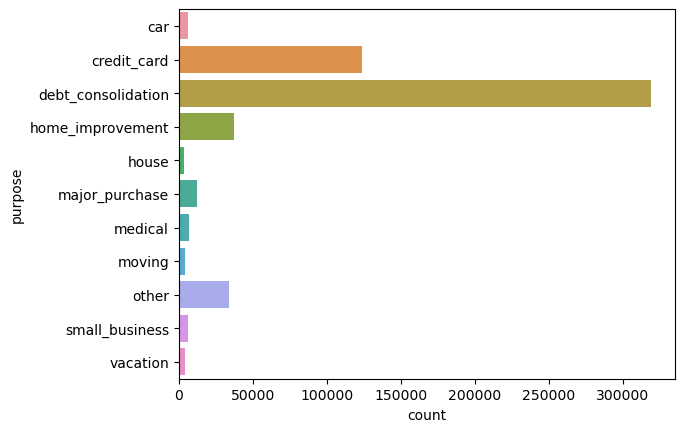

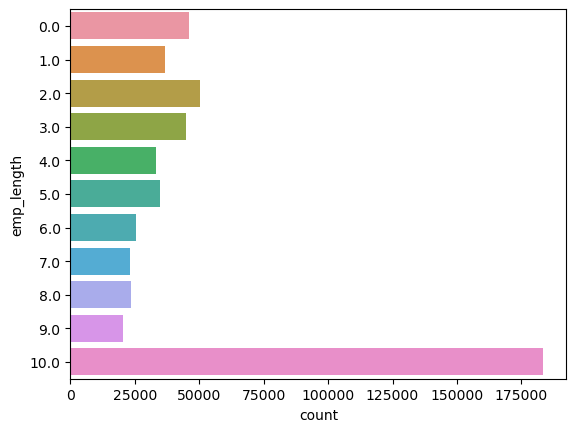

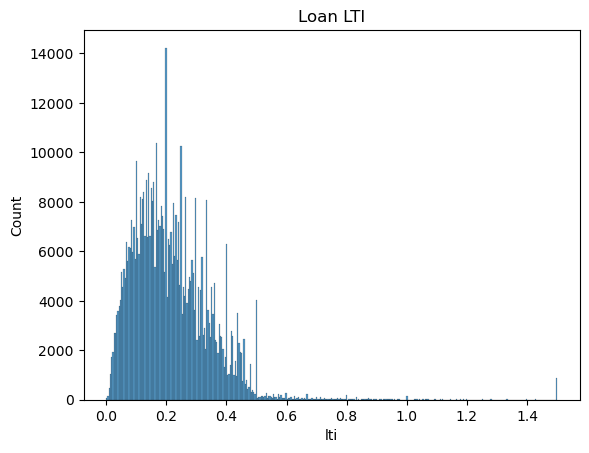

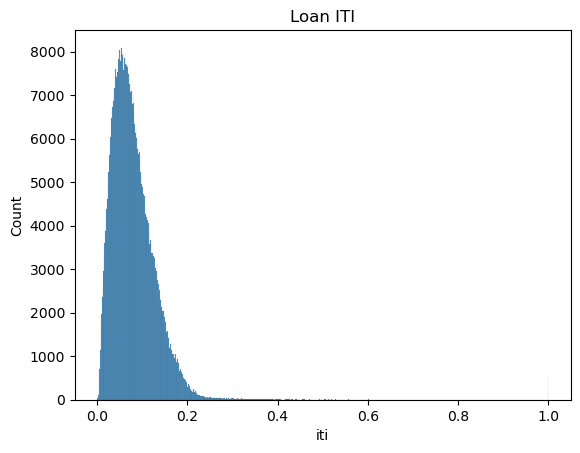

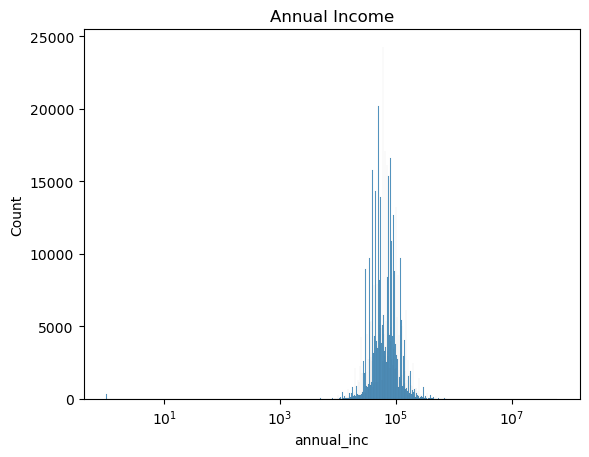

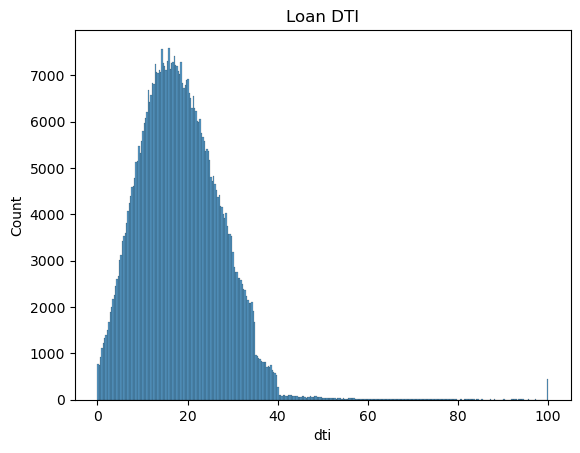

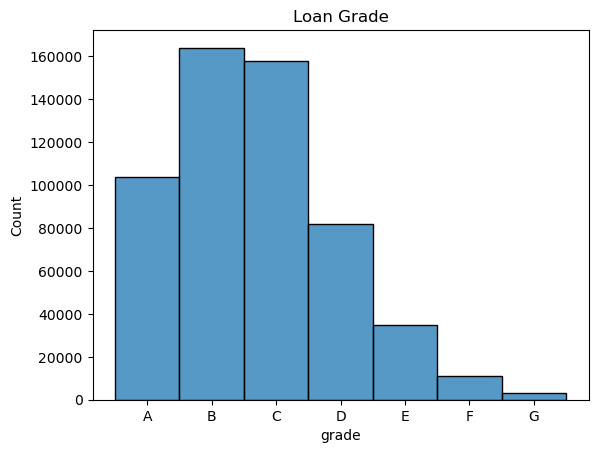

In [13]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)
plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()
sns.histplot(x='grade', data=df).set(title='Loan Grade')
plt.show()

Debt consolidation and credit card refinancing are the most frequent purposes for loans. It makes sense given maximum \\$40,000 loan size. Annual income is very approximately Gaussian and is centered around \\$100,000.
Key credit metrics as a fraction of income have pretty tight distributions with few outliers. It makes sense, since people with little to no income are unlikely to be good borrowers.

### EDA with target

Here I explore univariate relations between target and key features.

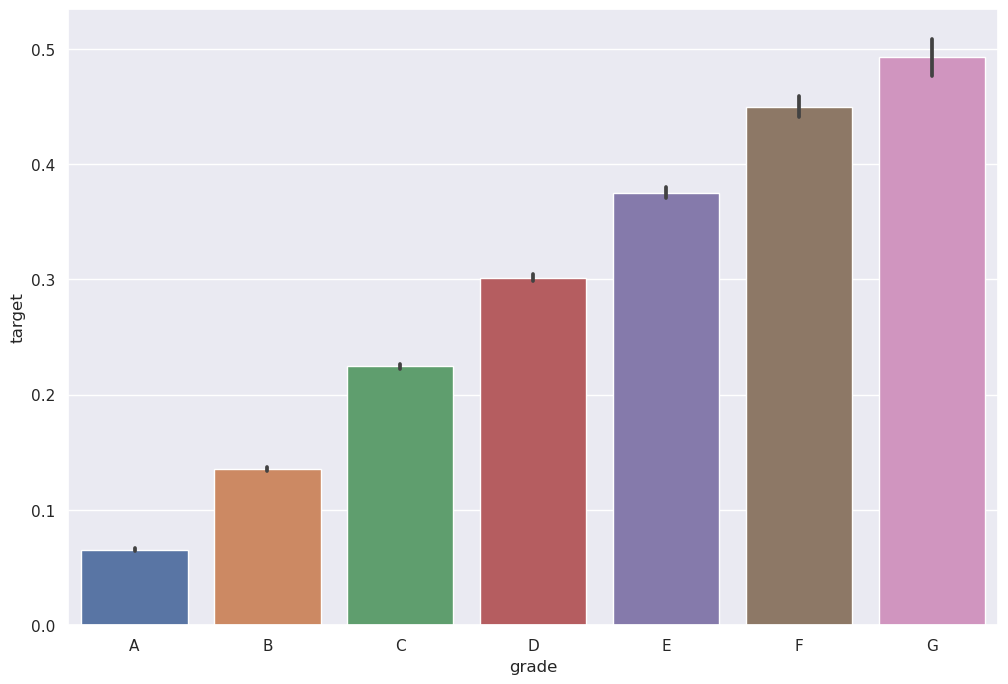

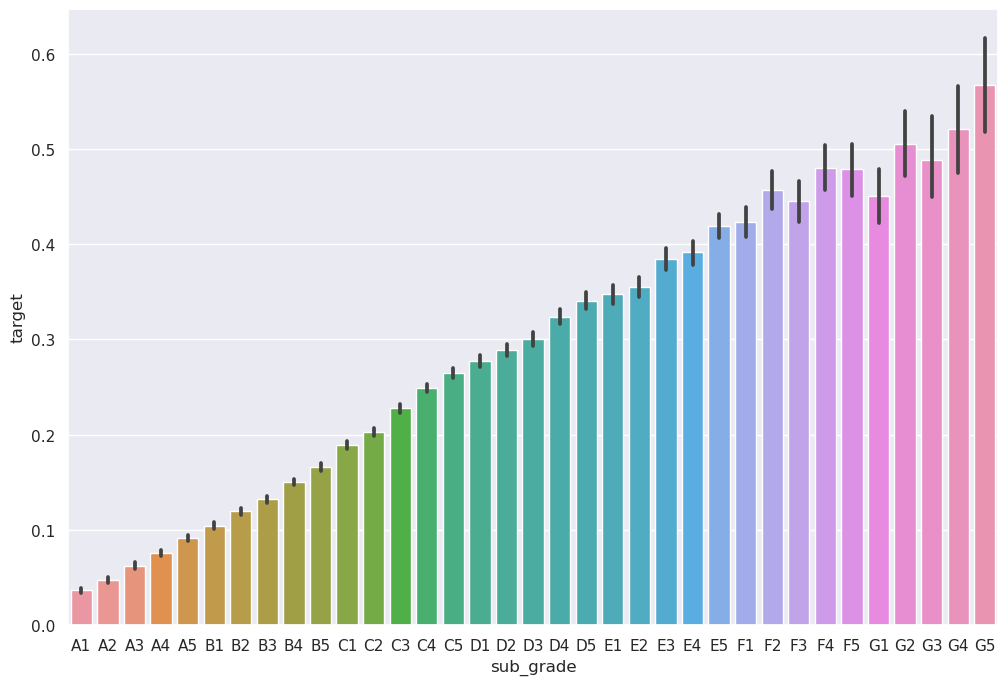

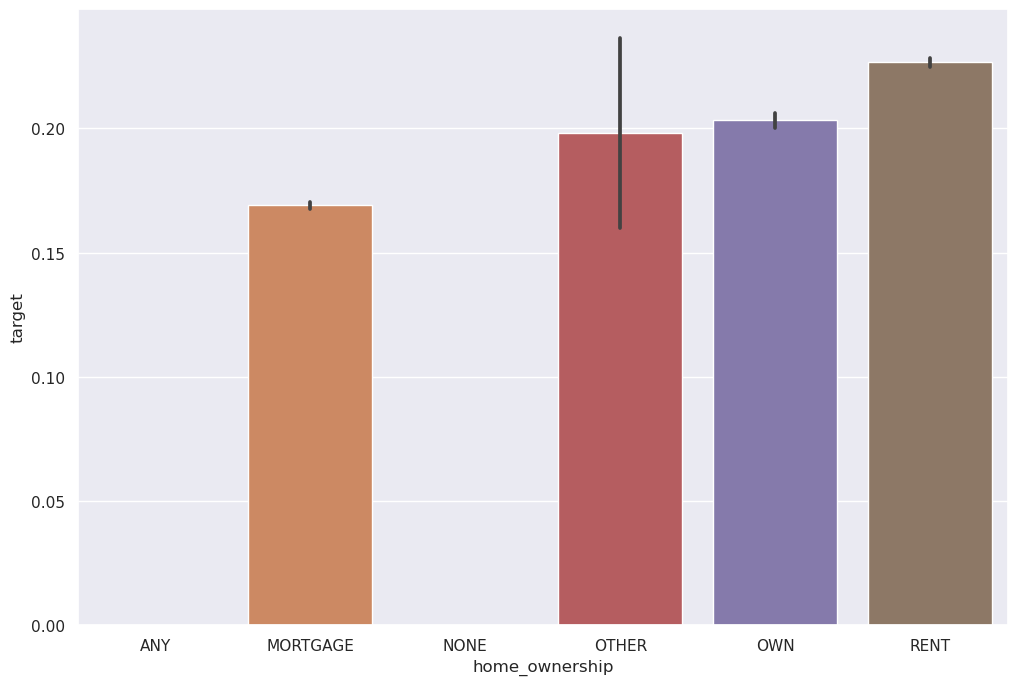

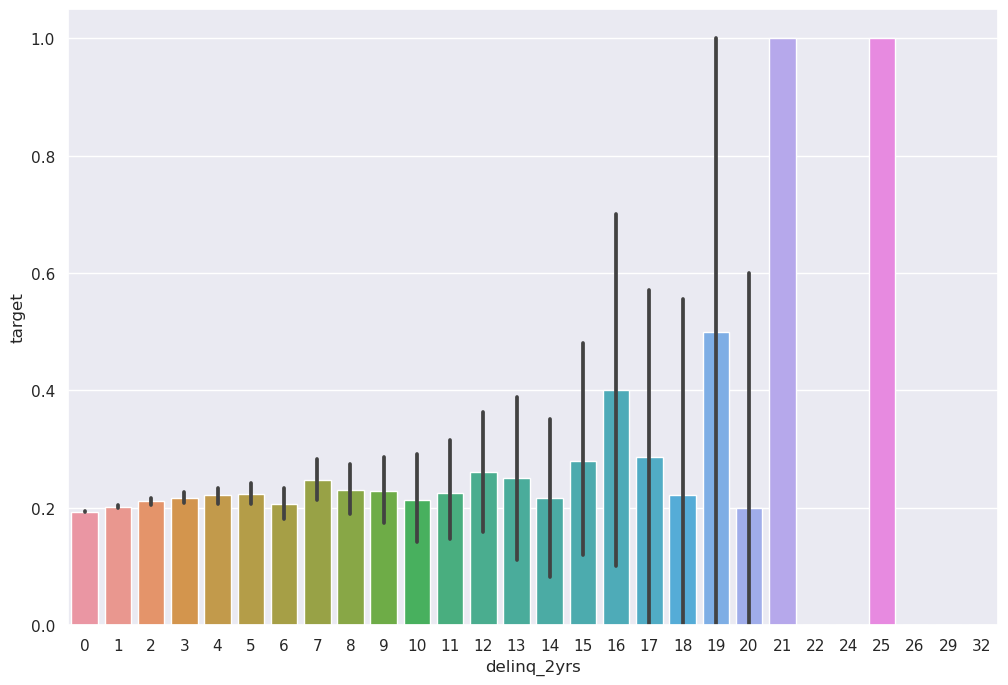

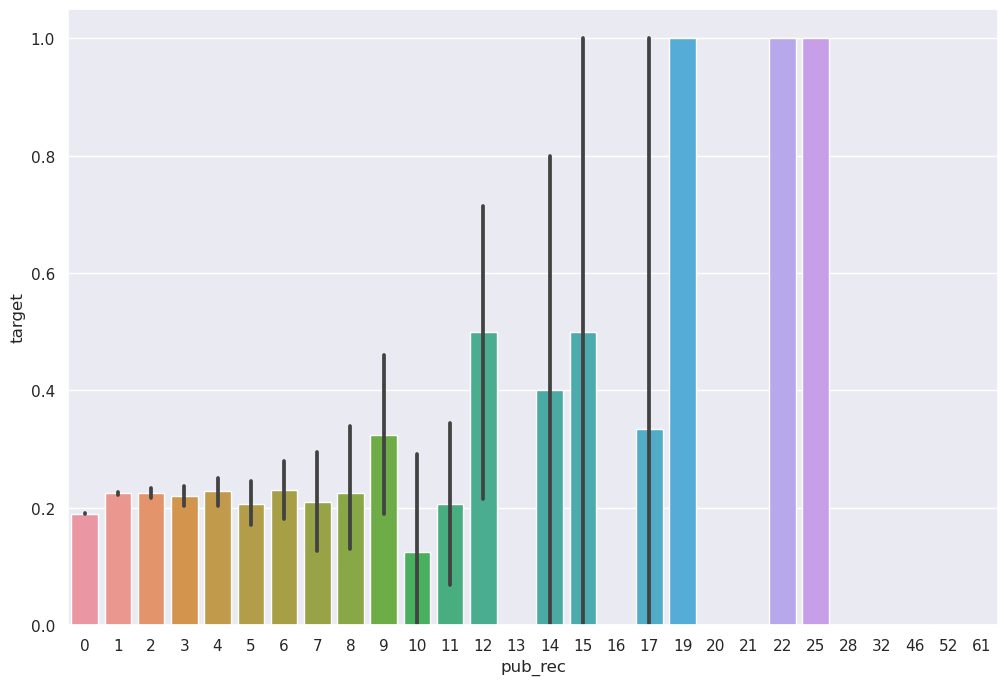

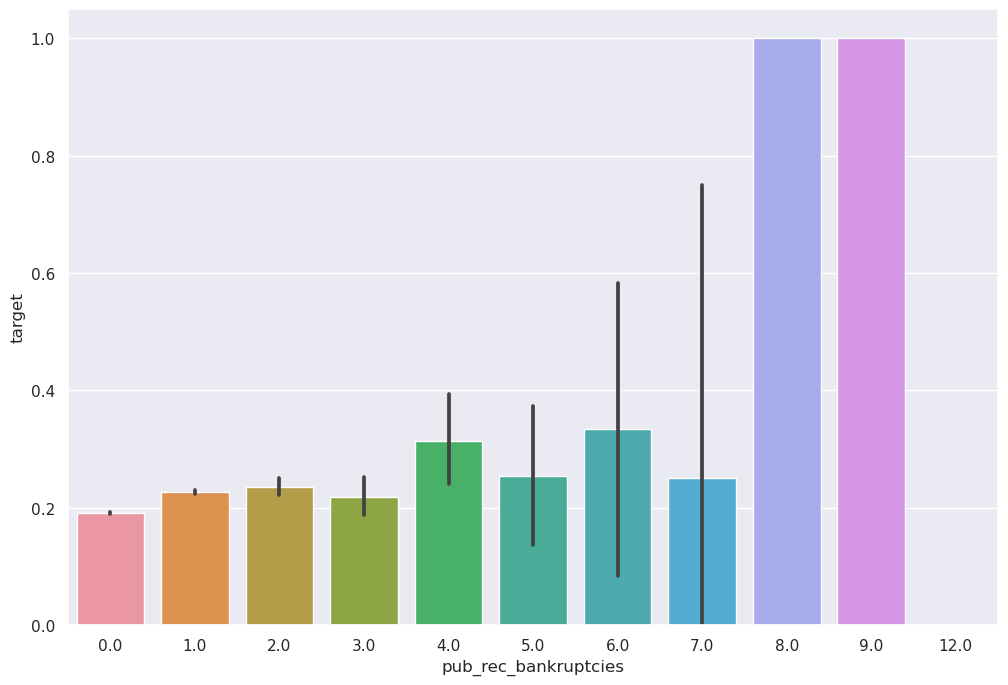

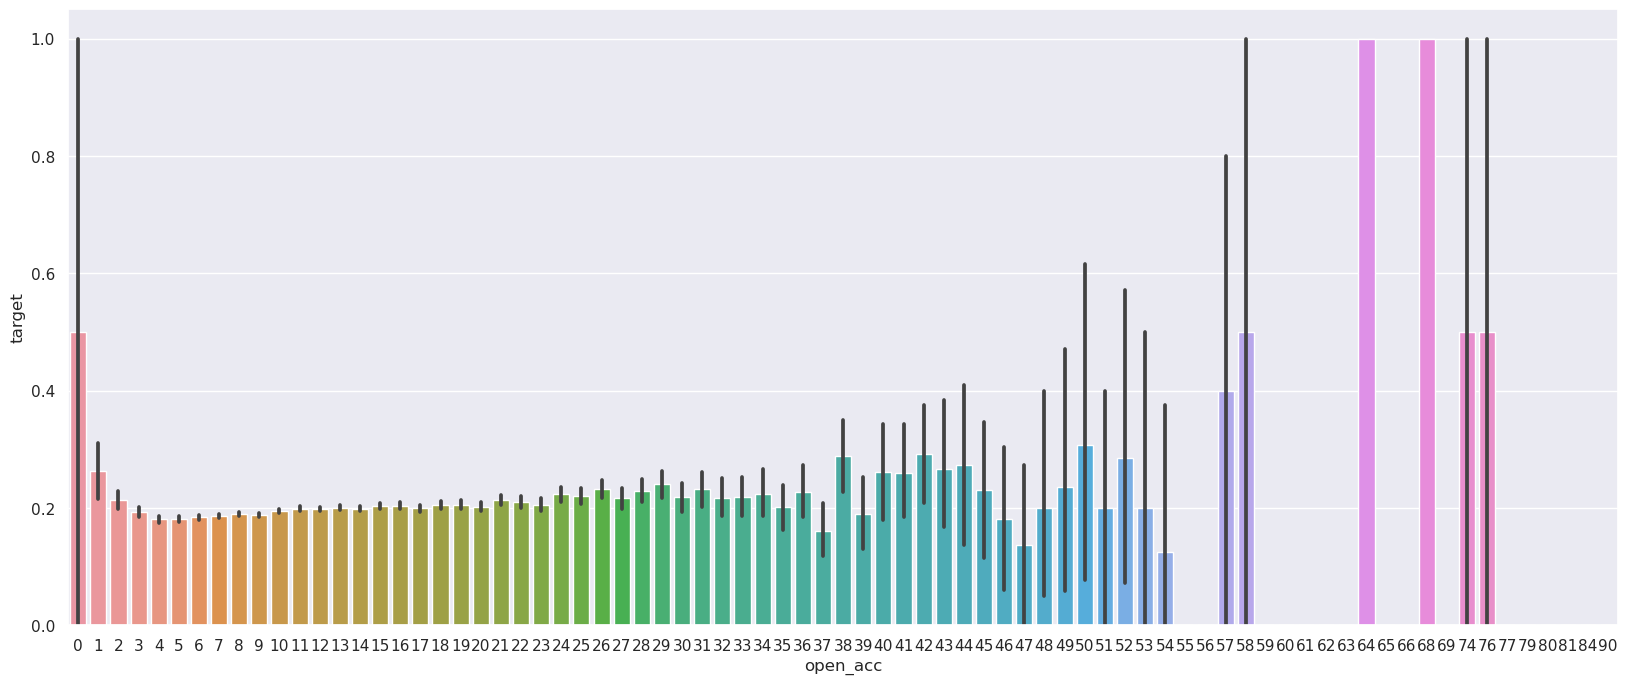

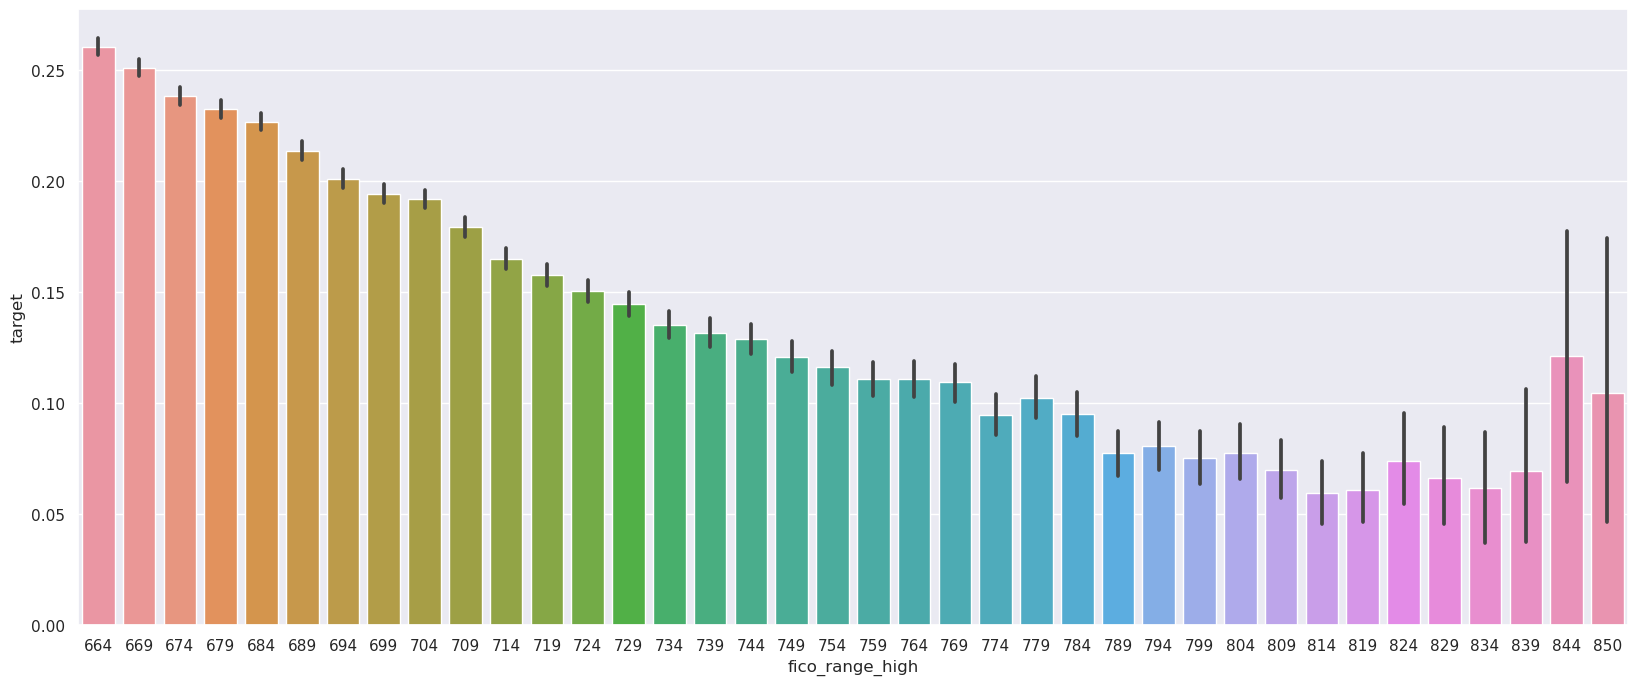

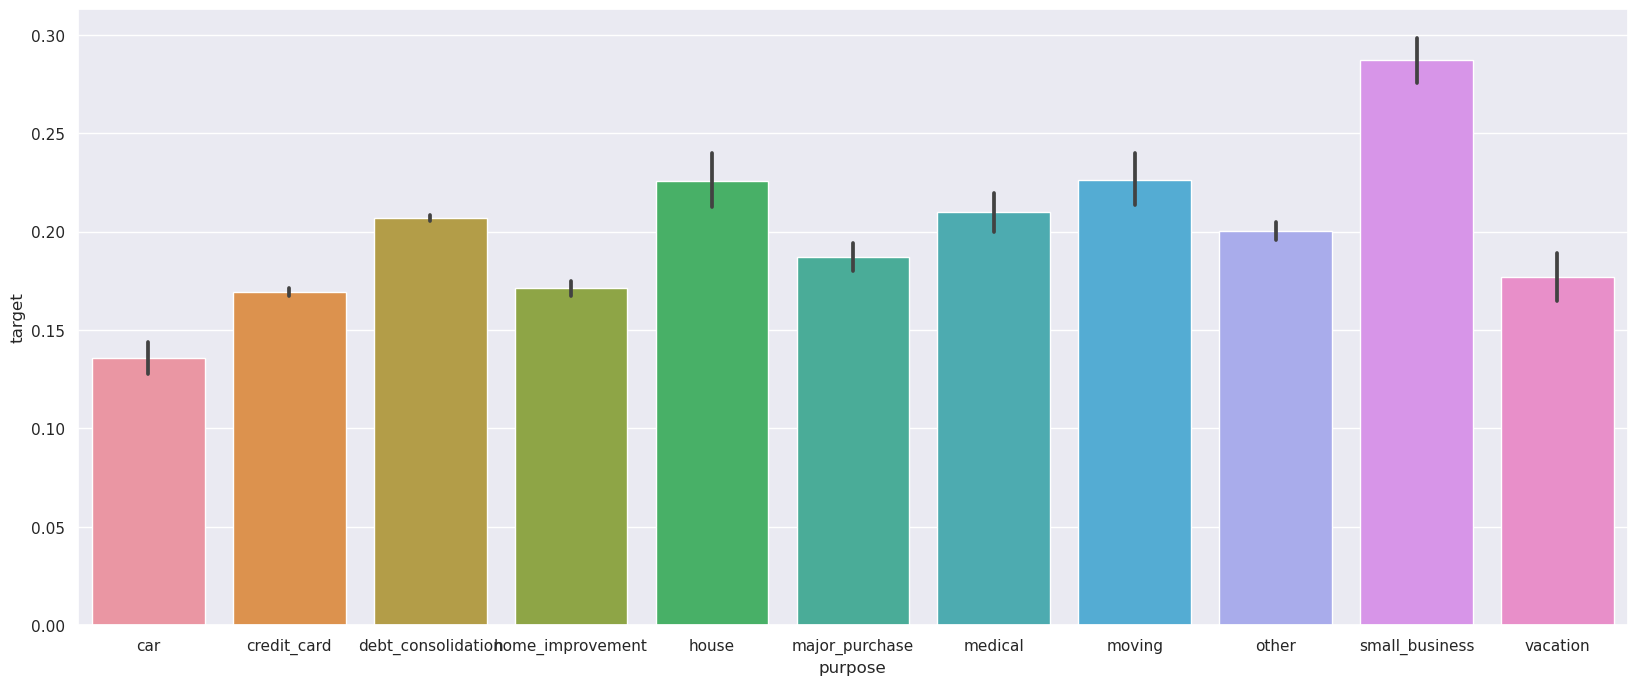

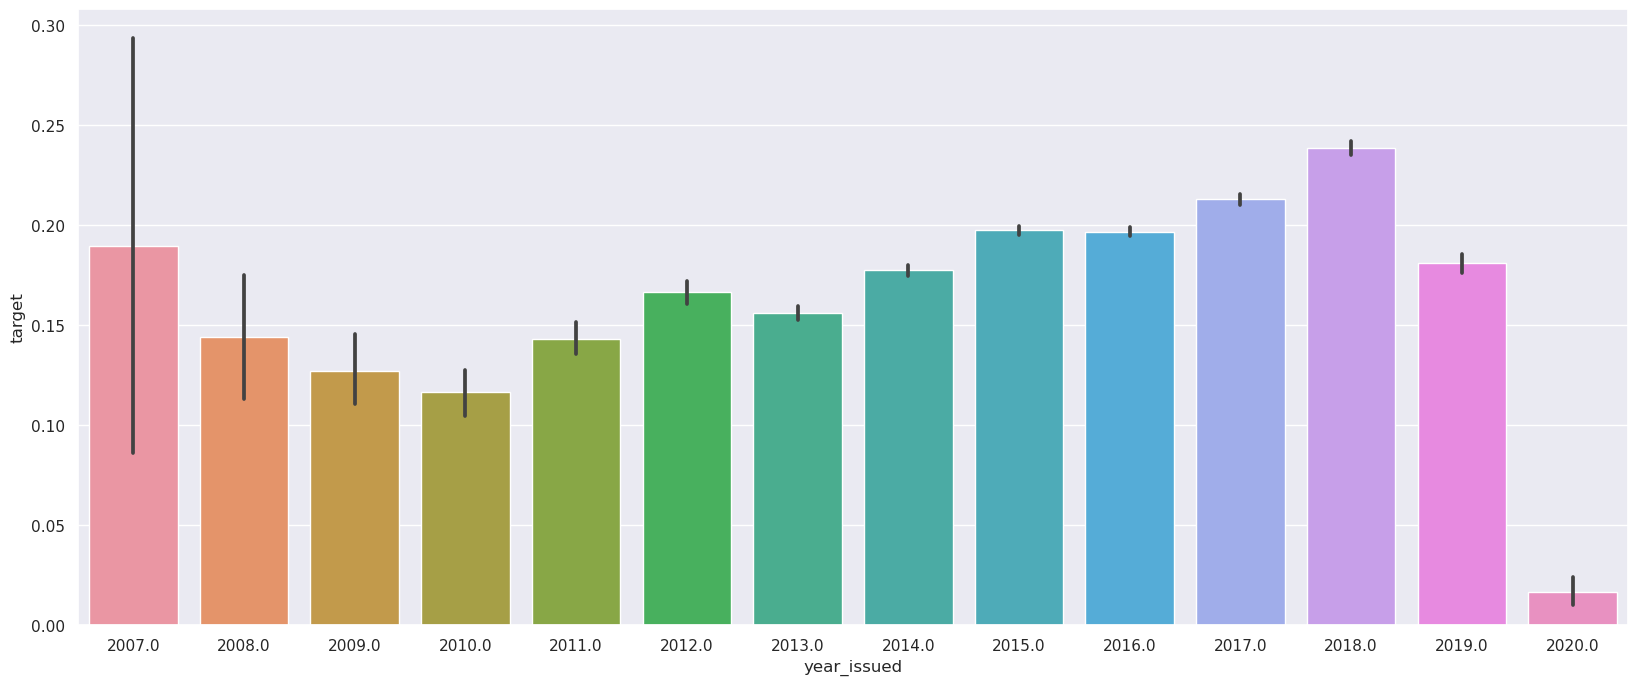

In [14]:
df.open_acc = df.open_acc.astype(int)
df.delinq_2yrs = df.delinq_2yrs.astype(int)
df.pub_rec = df.pub_rec.astype(int)
df.fico_range_high = df.fico_range_high.astype(int)

sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
#sns.barplot(x='total_acc', y='target', data=df)
#plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

Unsurprisingly, default rate is strongly positively correlated with loan grade. Low-grade loans are much more likely to default. Similarly, higher FICO ratings lead to lower default probability

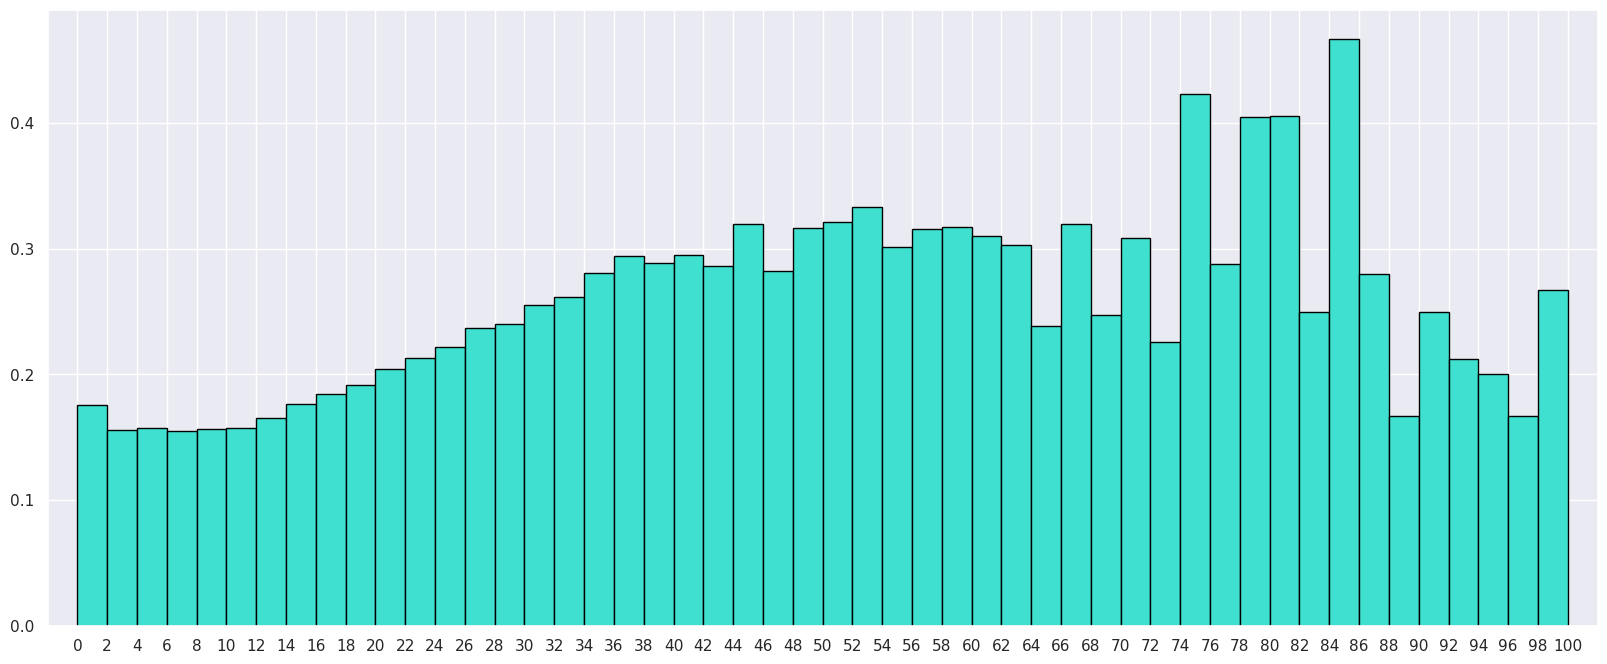

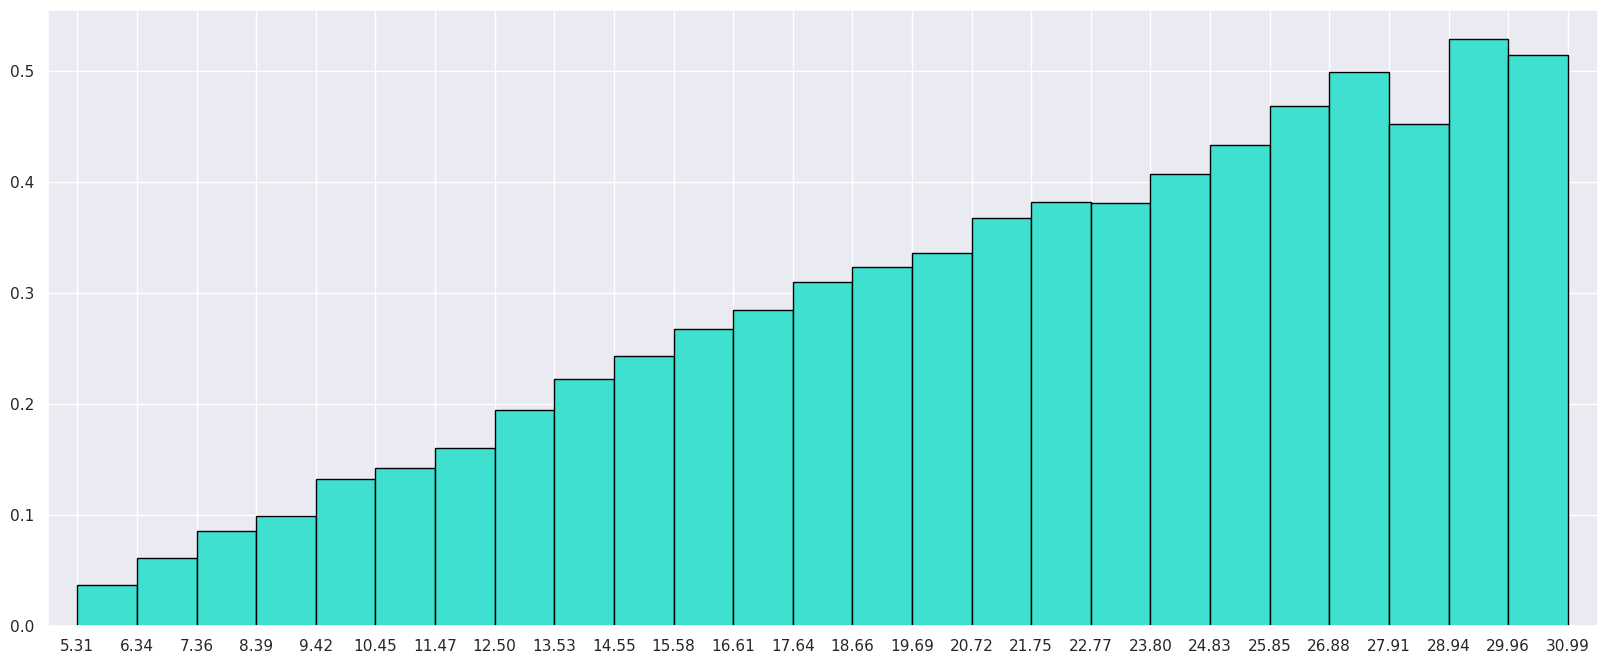

In [15]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) 
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

a = df.int_rate
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 26) 
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

There is strong positive relation between interest rate and default probability. This is to be expected, since otherwise it would mean very bad internal risk modeling at Lending Club.

There are interesting results regarding debt-to-income ratio. Default probability is predictably rising until DTI reaches 40%. Then it levels off and even to seem to fall after 60%. Due to sall number of loans with such a high DTI, it is hard to say whether this pattern is statistically significant.

### 5. Train-test split, missing values and feature engineering

In this section I fill missing values from train set and encode categorical features.

For categorical features, which will be target-encoded later, I fill missing values with 'MISSING' category.

To mitigate effect of outliers, I use median to impute values of missing numerical features.

In [16]:
#display(df.count())

features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 
                     'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'bc_open_to_buy','tot_cur_bal_inc', 'total_rev_inc',
                    'total_bal_ex_mort_inc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'avg_cur_bal_inc',
                    'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'tax_liens']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 
                      'num_tl_30dpd', 'num_tl_120dpd_2m', 'num_accts_ever_120_pd',
                     'acc_open_past_24mths', 'tot_coll_amt']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')
    
test_size = 0.25
df.reset_index(inplace=True, drop=True)
random.seed(2)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test00 = test.copy()
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())
    
train['total_rev_hi_lim'] = train.total_rev_inc.median()*train.annual_inc
test['total_rev_hi_lim'] = train.total_rev_inc.median()*test.annual_inc

train['total_bal_ex_mort'] = train.total_bal_ex_mort_inc.median()*train.annual_inc
test['total_bal_ex_mort'] = train.total_bal_ex_mort_inc.median()*test.annual_inc

train['tot_cur_bal'] = train.tot_cur_bal_inc.median()*train.annual_inc
test['tot_cur_bal'] = train.tot_cur_bal_inc.median()*test.annual_inc

train['avg_cur_bal'] = train.avg_cur_bal_inc.median()*train.annual_inc
test['avg_cur_bal'] = train.avg_cur_bal_inc.median()*test.annual_inc

display(train.count())

(417695, 77)

(139231, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,open_cl_ratio,joint,low_fico,was_bankrupt
0,2400.0,2400.0,2400.0,36.0,15.96,84.330002,small_business,real estate business,f,Individual,C,C5,739,MISSING,10.0,RENT,12252.0,606,IL,8.72,Not Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,2,0.0,NaN,10.0,NaN,NaN,2956.0,98.5,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,10.080974,0.0,0.0,0.195886,0.082595,0.241267,NaN,NaN,NaN,NaN,0.200000,0,0,0
1,5600.0,5600.0,5600.0,60.0,21.28,152.389999,small_business,Expand Business & Buy Debt Portfolio,f,Individual,F,F2,679,MISSING,4.0,OWN,40000.0,958,CA,5.55,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,11,0.0,NaN,13.0,NaN,NaN,5210.0,32.6,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,7.666140,0.0,1.0,0.140000,0.045717,0.130250,NaN,NaN,NaN,NaN,0.846154,0,0,0
2,12000.0,12000.0,12000.0,36.0,12.69,402.540009,debt_consolidation,Consolidation,f,Individual,B,B5,679,UCLA,10.0,OWN,75000.0,913,CA,10.78,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,12,0.0,NaN,34.0,NaN,NaN,23336.0,67.1,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,22.166095,0.0,0.0,0.160000,0.064406,0.311147,NaN,NaN,NaN,NaN,0.352941,0,0,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,open_cl_ratio,joint,low_fico,was_bankrupt
0,8000.0,8000.0,8000.0,36.0,16.29,282.410004,debt_consolidation,Debt Consolidation Loan,f,Individual,C,C4,674,Sierra College,10.0,MORTGAGE,60000.0,956,CA,28.90,Verified,4.0,13.0,31.0,1200.0,1200.0,31.0,5.0,3.0,0.0,0.0,10,5.0,4.0,58.0,14541.0,130865.0,18200.0,68.9,8200.0,4.0,6.0,7.0,26400.0,1,0.0,0.0,0,0.0,130865.0,0.0,0.0,50.0,91.000000,0.0,0.0,0.0,0.0,0.0,1.0,2012.0,9.0,2012.0,16.000329,0.0,0.0,0.133333,0.056482,0.303333,0.242350,2.181083,2.181083,0.440000,0.172414,0,0,0
1,24000.0,24000.0,24000.0,36.0,6.08,731.000000,debt_consolidation,Debt consolidation,w,Individual,A,A2,749,Production Team Lead,2.0,RENT,115000.0,941,CA,2.60,Source Verified,11.0,39.0,1200.0,1200.0,1200.0,1200.0,5.0,0.0,0.0,1.0,14,5.0,0.0,26.0,3669.0,51367.0,6048.0,8.2,64352.0,11.0,8.0,13.0,73800.0,0,0.0,0.0,0,0.0,51367.0,0.0,0.0,0.0,95.800003,5.0,0.0,0.0,0.0,0.0,0.0,2017.0,12.0,2017.0,10.335599,0.0,0.0,0.208696,0.076278,0.052591,0.031904,0.446670,0.446670,0.641739,0.538462,0,0,0
2,10800.0,10800.0,10800.0,36.0,5.32,325.239990,debt_consolidation,Debt consolidation,f,Individual,A,A1,729,lead pressman,10.0,MORTGAGE,85000.0,282,NC,9.37,Not Verified,14.0,18.0,1200.0,1200.0,18.0,18.0,0.0,0.0,0.0,0.0,8,2.0,3.0,17.0,26477.0,185342.0,6880.0,34.4,38.0,14.0,4.0,4.0,20000.0,1,0.0,0.0,0,0.0,9260.0,0.0,0.0,100.0,82.400002,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,7.0,2017.0,20.411097,0.0,0.0,0.127059,0.045916,0.080941,0.311494,2.180494,0.108941,0.235294,0.470588,0,0,0


loan_amnt                         417695
funded_amnt                       417695
funded_amnt_inv                   417695
term                              417695
int_rate                          417695
installment                       417695
purpose                           417695
title                             417695
initial_list_status               417695
application_type                  417695
grade                             417695
sub_grade                         417695
fico_range_high                   417695
emp_title                         417695
emp_length                        417695
home_ownership                    417695
annual_inc                        417695
zip_code                          417695
addr_state                        417695
dti                               417695
verification_status               417695
mo_sin_rcnt_tl                    417695
mths_since_last_delinq            417695
mths_since_last_major_derog       417695
mths_since_last_

### Categorical features encoding

Depending of feature type, I use three encoding types:

- Target encoding. I do it for feature with more than 5 unique values.
- One-hot encoding. I use it for features with less than 5 unique values.
- Frequency encoding. 'Title' feature only.

In [17]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

freq_enc = (train.groupby('title').size()) / len(train)
train['title_fencoded'] = train['title'].apply(lambda x : freq_enc[x])
test['title_fencoded'] = test['title'].apply(lambda x : freq_enc[x])

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

67.33843040466309

9.75447964668274

(417695, 78)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,open_cl_ratio,joint,low_fico,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,2400.0,2400.0,2400.0,36.0,15.96,84.330002,f,Individual,739,10.0,12252.0,8.72,Not Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,2,0.0,1.0,10.0,1395.094360,15021.462891,2956.0,98.5,5201.0,8.0,5.0,7.0,4717.02002,0,0.0,0.0,0,0.0,6950.457520,0.0,0.0,40.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,10.080974,0.0,0.0,0.195886,0.082595,0.241267,0.113867,1.226042,0.567292,0.385,0.200000,0,0,0,0.000002,0.255293,0.261715,0.284216,0.194365,0.170245,0.175577,0.219905,0.225603
1,5600.0,5600.0,5600.0,60.0,21.28,152.389999,f,Individual,679,4.0,40000.0,5.55,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,11,0.0,1.0,13.0,4554.666504,49041.667969,5210.0,32.6,5201.0,8.0,5.0,7.0,15400.00000,0,0.0,0.0,0,0.0,22691.667969,0.0,0.0,40.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,7.666140,0.0,1.0,0.140000,0.045717,0.130250,0.113867,1.226042,0.567292,0.385,0.846154,0,0,0,0.000002,0.472844,0.261715,0.284216,0.194365,0.196244,0.196360,0.467014,0.200539
2,12000.0,12000.0,12000.0,36.0,12.69,402.540009,f,Individual,679,10.0,75000.0,10.78,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,12,0.0,1.0,34.0,8540.000000,91953.125000,23336.0,67.1,5201.0,8.0,5.0,7.0,28875.00000,0,0.0,0.0,0,0.0,42546.875000,0.0,0.0,40.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,22.166095,0.0,0.0,0.160000,0.064406,0.311147,0.113867,1.226042,0.567292,0.385,0.352941,0,0,0,0.003019,0.160143,0.194365,0.206147,0.198591,0.184489,0.196360,0.132567,0.200539
3,3000.0,3000.0,3000.0,36.0,9.91,96.680000,f,Individual,709,3.0,15000.0,12.56,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,11,0.0,1.0,11.0,1708.000000,18390.625000,7323.0,43.1,5201.0,8.0,5.0,7.0,5775.00000,0,0.0,0.0,0,0.0,8509.375000,0.0,0.0,40.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,8.419064,0.0,0.0,0.200000,0.077344,0.488200,0.113867,1.226042,0.567292,0.385,1.000000,0,0,0,0.000002,0.100376,0.194365,0.170142,0.194365,0.170245,0.175577,0.132567,0.225603
4,10000.0,10000.0,10000.0,36.0,15.27,347.980011,f,Individual,674,4.0,42000.0,18.60,Not Verified,120.0,61.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,14,0.0,1.0,28.0,4782.399902,51493.750000,24043.0,70.2,5201.0,8.0,5.0,7.0,16170.00000,0,0.0,0.0,0,0.0,23826.250000,0.0,0.0,40.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,13.166595,0.0,0.0,0.238095,0.099423,0.572452,0.113867,1.226042,0.567292,0.385,0.500000,0,0,0,0.000136,0.243565,0.194365,0.171491,0.176696,0.218160,0.196360,0.219905,0.225603


loan_amnt                         417695
funded_amnt                       417695
funded_amnt_inv                   417695
term                              417695
int_rate                          417695
installment                       417695
initial_list_status               417695
application_type                  417695
fico_range_high                   417695
emp_length                        417695
annual_inc                        417695
dti                               417695
verification_status               417695
mo_sin_rcnt_tl                    417695
mths_since_last_delinq            417695
mths_since_last_major_derog       417695
mths_since_last_record            417695
mths_since_recent_bc_dlq          417695
mths_since_recent_revol_delinq    417695
num_tl_op_past_12m                417695
inq_last_6mths                    417695
inq_fi                            417695
inq_last_12m                      417695
open_acc                          417695
acc_open_past_24

In [18]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", 
     OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), 
     cat_features_ohe)], 
    remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_train.columns = X_train.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
X_test.columns = X_test.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')

print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()
X_test_0 = X_test.copy()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,open_cl_ratio,joint,low_fico,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,8000.0,8000.0,8000.0,36.0,16.29,282.410004,f,Individual,674,10.0,60000.0,28.90,Verified,4.0,13.0,31.0,1200.0,1200.0,31.0,5.0,3.0,0.0,0.0,10,5.0,4.0,58.0,6832.000000,73562.500000,18200.0,68.9,8200.0,4.0,6.0,7.0,23100.000000,1,0.0,0.0,0,0.0,34037.500000,0.0,0.0,50.0,91.000000,0.0,0.0,0.0,0.0,0.0,1.0,2012.0,9.0,2012.0,16.000329,0.00000,0.133333,0.056482,0.303333,0.242350,2.181083,2.181083,0.440000,0.172414,0,0,0,0.002016,0.248336,0.195502,0.20653,0.150051,0.180126,0.196354,0.224318,0.169192
1,24000.0,24000.0,24000.0,36.0,6.08,731.000000,w,Individual,749,2.0,115000.0,2.60,Source Verified,11.0,39.0,1200.0,1200.0,1200.0,1200.0,5.0,0.0,0.0,1.0,14,5.0,0.0,26.0,13094.666016,140994.796875,6048.0,8.2,64352.0,11.0,8.0,13.0,44275.000000,0,0.0,0.0,0,0.0,65238.542969,0.0,0.0,0.0,95.800003,5.0,0.0,0.0,0.0,0.0,0.0,2017.0,12.0,2017.0,10.335599,0.00000,0.208696,0.076278,0.052591,0.031904,0.446670,0.446670,0.641739,0.538462,0,0,0,0.506063,0.048491,0.170356,0.20653,0.211257,0.140093,0.196354,0.066370,0.225857
2,10800.0,10800.0,10800.0,36.0,5.32,325.239990,f,Individual,729,10.0,85000.0,9.37,Not Verified,14.0,18.0,1200.0,1200.0,18.0,18.0,0.0,0.0,0.0,0.0,8,2.0,3.0,17.0,9678.666016,104213.539062,6880.0,34.4,38.0,14.0,4.0,4.0,32725.000000,1,0.0,0.0,0,0.0,48219.792969,0.0,0.0,100.0,82.400002,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,7.0,2017.0,20.411097,0.00000,0.127059,0.045916,0.080941,0.311494,2.180494,0.108941,0.235294,0.470588,0,0,0,0.506063,0.037450,0.220692,0.20653,0.211257,0.193501,0.204223,0.066370,0.169192
3,29850.0,29850.0,29850.0,60.0,17.14,744.099976,w,Individual,709,6.0,65000.0,20.68,Source Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,1.0,0.0,0.0,10,1.0,0.0,19.0,7401.333008,79692.710938,34550.0,88.8,390.0,3.0,6.0,8.0,25025.000000,0,0.0,0.0,0,0.0,36873.960938,0.0,0.0,100.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,1.0,2015.0,20.167423,0.00000,0.459231,0.137372,0.531538,0.080600,0.644785,0.644785,0.598462,0.526316,0,0,0,0.506063,0.325822,0.195502,0.20653,0.211257,0.180379,0.185176,0.300820,0.225857
4,2200.0,2200.0,1950.0,36.0,10.72,71.739998,f,Individual,704,0.0,12180.0,8.87,Verified,7.0,1200.0,1200.0,102.0,1200.0,1200.0,2.0,0.0,0.0,1.0,4,3.0,1.0,6.0,1386.895996,14933.187500,2139.0,31.0,1909.0,7.0,3.0,4.0,4689.299805,0,0.0,0.0,1,1.0,6909.612793,0.0,0.0,0.0,100.000000,2.0,0.0,0.0,0.0,0.0,0.0,2019.0,1.0,2019.0,19.168087,0.05217,0.180624,0.070680,0.175616,0.043924,0.175616,0.175616,0.566502,0.666667,0,0,1,0.506063,0.119517,0.263386,0.20653,0.211257,0.190497,0.213863,0.136016,0.225857


Number of features before transaformation:  (417695, 77)
time to do feature proprocessing:  11.235405206680298
Number of features after transaformation:  (417695, 79)


### 6. Modeling

Here I will build 3 models to predict loan bankruptcies:

- Baseline XGBoost model (default hyperparameters).
- XGBoost model with hyperparameter optimization using Optuna.

'Train Accuracy: '

0.8200337566884928

'F1 score: '

0.24217434698012966

'ROCAUC: '

0.5653263321535749

'PRAUC: '

0.4865007320946046

'R10P: '

0.7414935123854459

'Test Accuracy: '

0.8091301506130101

'F1 score: '

0.19178248836714212

'ROCAUC: '

0.5467552125720768

'PRAUC: '

0.39871794364493607

'R10P: '

0.5700503355704698

11.929976224899292

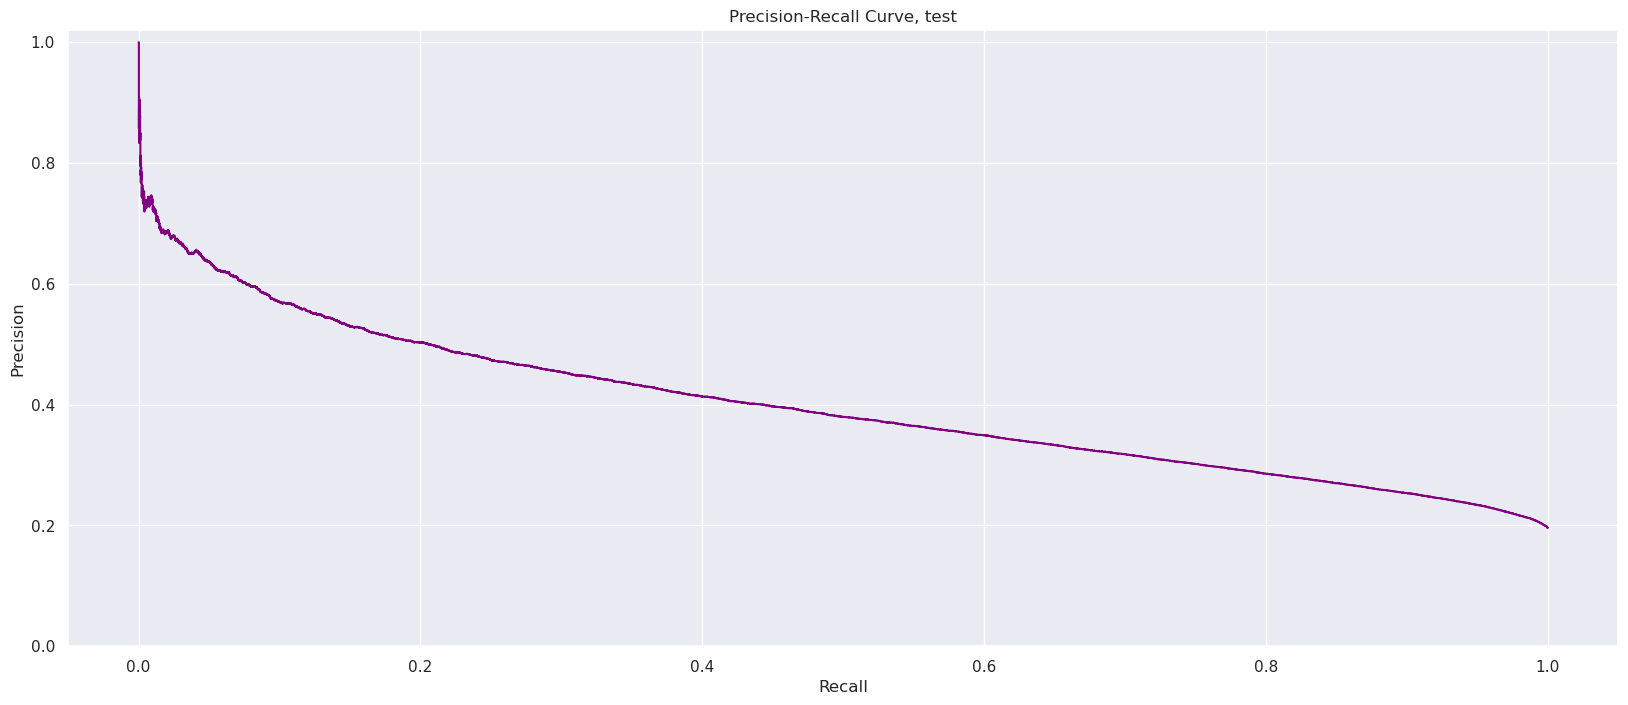

In [19]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)
xgbb = XGBClassifier(tree_method = 'gpu_hist',
                    n_estimators = 200,
                    eta = 0.08,
                    max_depth = 5,
                    subsample = 0.8,
                    colsample_bytree = 0.6)

xgbb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.095)&(recall_t<0.105)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r10prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.095)&(recall_t<0.105)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r10prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R10P: ', r10prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R10P: ', r10prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

In [20]:
# xgb baseline:

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgbb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.095)&(recall_t<0.105)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r10prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgbb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.095)&(recall_t<0.105)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r10prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train, xgbb.predict(X_train)))
display('F1 score: ', f1_score(y_train, xgbb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train, xgbb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R10P: ', r10prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test, xgbb.predict(X_test)))
display('F1 score: ', f1_score(y_test, xgbb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test, xgbb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R10P: ', r10prec_test)
display(time.time()-time1)

'Train Accuracy: '

0.8125091274733957

'F1 score: '

0.17664746204634343

'ROCAUC: '

0.5439173550358183

'PRAUC: '

0.4260434070549844

'R10P: '

0.625

'Test Accuracy: '

0.8102505907448773

'F1 score: '

0.16403505996266177

'ROCAUC: '

0.5396569724588173

'PRAUC: '

0.4040412304177835

'R10P: '

0.5916775032509753

16.64748764038086

In [21]:
# add optuna xgb

### 7. Model interpretation

In this section I use SHAP library in order to provide interpretation of the results.

Feature importances tell us which features give the model its predictive power. SHAP values indicate how certain values of each feature affect model predictions.

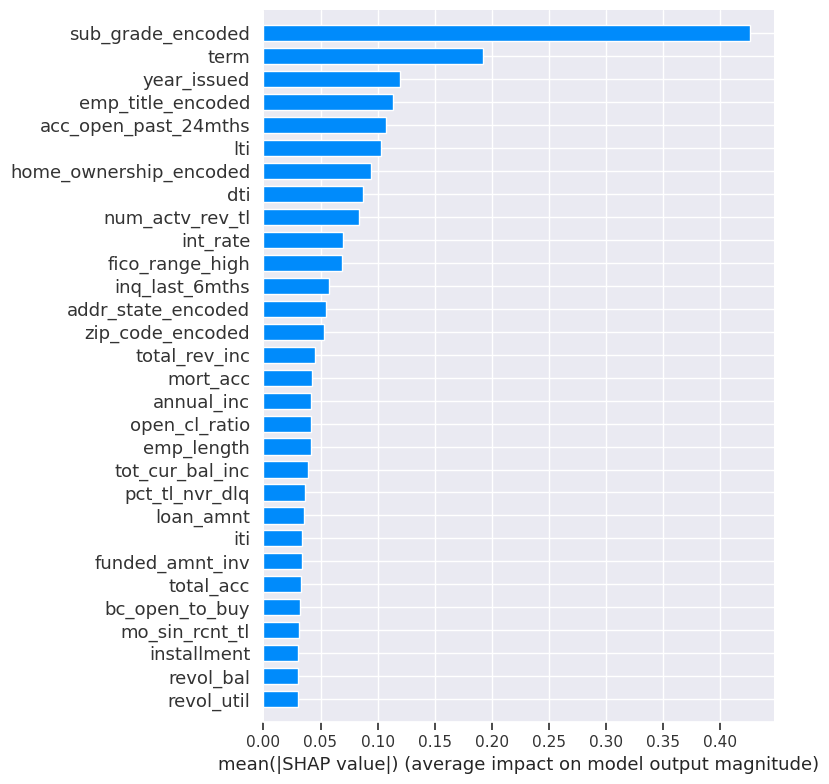

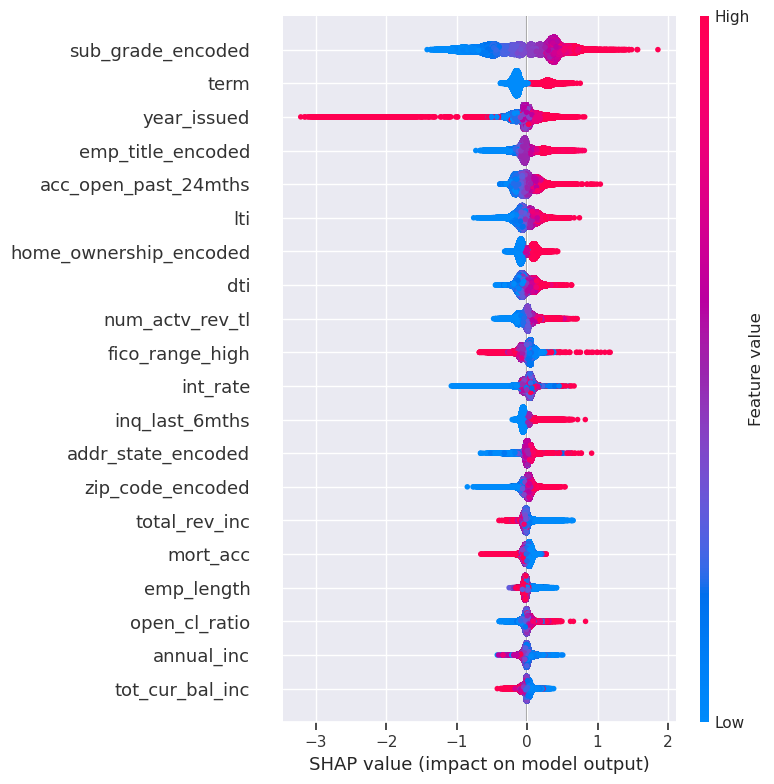

In [22]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
#display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

We can see that subgrade is the most important feature. SHAP values of encoded subgrade are positively related to loan default risk. This is to beexpected, since by construction target encodings measure average value of a target. So we would expect all target-encoded features to positively predict defaults. 

The other important features are loan term, number of accounts, opened in the past 24 months, LTI (Loan-to_Income ratio) and DTI (Debt-toIncome ratio). Their partial efects make sense: Higher LTI, DTI and higher number of recently opened accounts are positively related to loan defaults.

The code below explains model predictions for a specific instances. For example, it illustrates why the model predicts no default for a loan at index 1 and default for a loan with index 10.

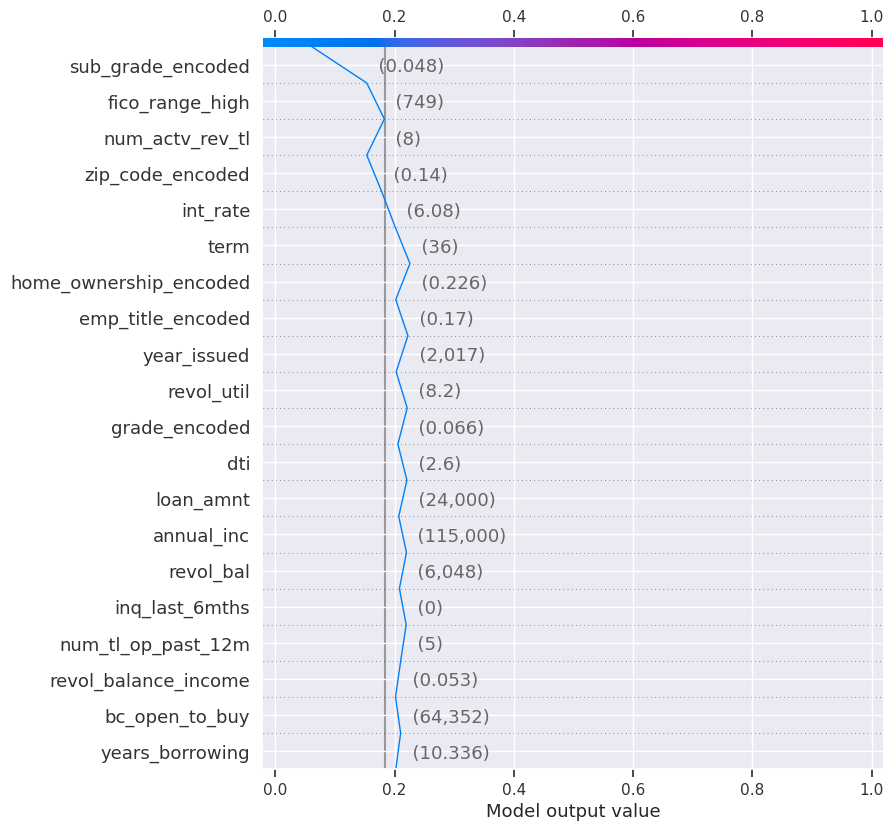

In [23]:
indx = 1
#fig = plt.subplots(figsize=(2,2),dpi=200)
ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")
shap.initjs()
shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

This loan has high subgrade and low interest rate. Its other features are the features, common for well-performing loans. Thus model confidently predicts no default.

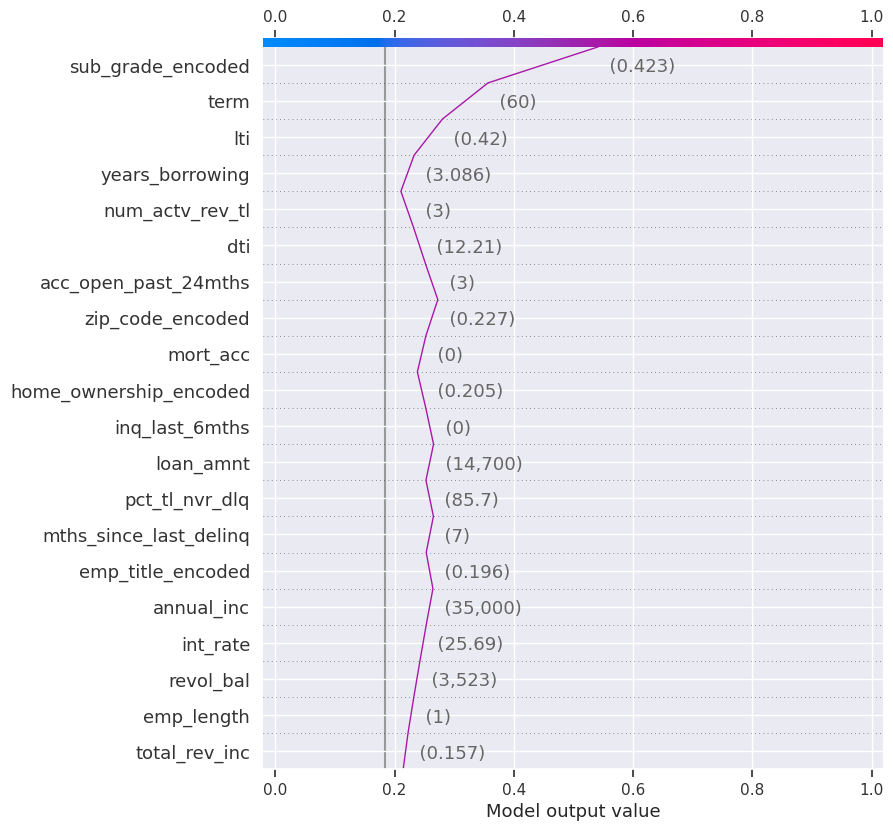

In [24]:
indx = 10
#fig = plt.subplots(figsize=(2,2),dpi=200)
ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")
shap.initjs()
shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

This loan looks very different. It has very low rating (i.e., subgrade), high LTI, high interest rate and long maturity. These features explain why the model assigns default probability of 55% to this loan.

### 8. Business implications

#### 8.1 Is this model useful?

This project is a perfect illustration of how machine learning can create value if we think hard about business problem at hand rather than focusing on a few narrow model evaluation metrics.

If you view this project as a purely data mining/prediction exercise, then it is arguably a failure. Model accuracy is 81% which barely beats 80% from a trivial model, always predicting no default. F1 score is only 18%, which is not impressive. ROCAUC is 55% which is barely better than a random guess.

However, the predictive model above can create value if used properly. Let me show how.

Precision-recall curve above shows that model is actually very good in predicting defaults for around 20% of defaulted loans. For example, its precision at 10% recall is 60%. This means that if we use the model only to predict default for those loans it is most confident about, we can avoid at least 10% of credit losses while forgoing relatively few profitable lending opportunities. 

#### 8.2 How much value does it create?

To quantify value created by the model, I consider a problem faced by all Lending Club investors as a group to maximize their investment profit. They can do so by avoiding x% of the riskiest loans as determined by my model. In order to keep this analysis simple and accessible to wider audience I abstract away from time discounting, compound interest and present value calculations. All the calculations below assume simple interest.

The decision of an investor to avoid financing x% of the riskiest loans is a tradeoff between a foregone interest income and a credit loss. 

If investors invest in a loan:
- They receive interest income in the future as long as the borrower repays a loan.
- They suffer credit losses and receive only recovered amount if the borrower defaults.

So their total dollar return (TR) from investment is as follows:

$$ TR_{Invest} = \sum_{j \in RepaidLoans}LoanAmount_j*(r_j+1) + \sum_{k \in DefaultedLoans}Recovery_k.$$

Their outisde riskless option is to invest in Treasury bills with similar maturity. Average yield of 3-year treasury notes over this sample period [is around 2%](https://fred.stlouisfed.org/series/DGS3). So their TR if they forgo such loans is:

$$ TR_{Forgo} = \sum_{i \in AllLoans} LoanAmount_i*(1.02).$$

Thus the decision to issue such loans depends on which part dominates. Savings of investors from avoiding top x% riskiest loans are the difference between the returns fom investing in T-notes and LendingClub loans:

$$ \sum_{i \in AllLoans} LoanAmount_i*(1.02) - \sum_{j \in RepaidLoans}LoanAmount_j*(r_j+1) + \sum_{k \in DefaultedLoans}Recovery_k $$

The expression above is the value created from avoiding the riskiest loans. For example, if I use the model to identify top 10% riskiest loans, then AllLoans will be the loans with 10% of the highest predicted default probabilities. RepaidLoans and DefaultedLoans will be subsets of those loans.

The code below uses loan_amnt, int_rate and recovery features to calculate this value created. Risky loans are defined based on threshold, necessary to reach 10% recall.



In [25]:
recoveries['total_recovery'] = recoveries.total_rec_prncp + recoveries.total_rec_int + recoveries.recoveries
recoveries['tot_recov_rp'] = recoveries.total_recovery/recoveries.loan_amnt
recoveries['tot_recov_rt'] = recoveries.total_recovery/(recoveries.loan_amnt*((recoveries.int_rate/100+1)**3))
# in a few cases the recoveries seem to exceed total proceeds.
# this may be the result of ignoring time discounting and compound interest in my calculations
# ior those may be rarer 60-months loans. so i do not adjust such cases.
display(recoveries.describe(), recoveries.head())

,recoveries,loan_amnt,int_rate,total_rec_prncp,total_rec_int,total_recovery,tot_recov_rp,tot_recov_rt
count,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000
mean,1367.722534,15871.564453,15.650086,4618.821777,2792.090820,8778.634766,0.562341,0.368011
std,2009.665771,9072.825195,5.027926,4380.201660,2847.963135,7124.014648,0.293171,0.196640
min,0.000000,1000.000000,5.310000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9300.000000,11.990000,1586.069946,873.750000,3684.020020,0.333000,0.212242
50%,720.330017,14600.000000,14.990000,3291.959961,1856.170044,6859.430176,0.525157,0.340963
75%,1896.729980,21000.000000,18.550000,6198.540039,3728.580078,11852.330078,0.769617,0.508548
max,39859.550781,40000.000000,30.990000,38694.070312,28005.960938,61740.929688,1.764027,1.090076


,id,loan_status,recoveries,loan_amnt,int_rate,total_rec_prncp,total_rec_int,total_recovery,tot_recov_rp,tot_recov_rt
8,1071795,Charged Off,190.539993,5600.0,21.28,162.020004,294.940002,647.500000,0.115625,0.064816
21,1039153,Charged Off,9.200000,21000.0,12.42,10694.959961,3330.439941,14034.600586,0.668314,0.470381
24,1069559,Charged Off,275.019989,6000.0,11.71,1305.579956,475.250000,2055.849854,0.342642,0.245790
27,1069657,Charged Off,263.000000,5000.0,16.77,629.049988,719.109985,1611.159912,0.322232,0.202383
50,1069248,Charged Off,222.809998,15000.0,9.91,13556.450195,2374.340088,16153.599609,1.076907,0.811085


In [26]:
X_test = X_test_0.copy()
test = X_test[['loan_amnt', 'int_rate']]
test.int_rate = test.int_rate/100+1
test['y_pred'] = xgb.predict_proba(X_test)[:,1]
test['id'] = test00.id
test['y'] = y_test
test = pd.merge(test, recoveries[['id', 'loan_amnt', 'int_rate', 'total_recovery']], on='id', how = 'left')
display(recoveries.head(), test.head())
display(test.loc[test.y==0].count(), test.loc[test.y==1].count())

,id,loan_status,recoveries,loan_amnt,int_rate,total_rec_prncp,total_rec_int,total_recovery,tot_recov_rp,tot_recov_rt
8,1071795,Charged Off,190.539993,5600.0,21.28,162.020004,294.940002,647.500000,0.115625,0.064816
21,1039153,Charged Off,9.200000,21000.0,12.42,10694.959961,3330.439941,14034.600586,0.668314,0.470381
24,1069559,Charged Off,275.019989,6000.0,11.71,1305.579956,475.250000,2055.849854,0.342642,0.245790
27,1069657,Charged Off,263.000000,5000.0,16.77,629.049988,719.109985,1611.159912,0.322232,0.202383
50,1069248,Charged Off,222.809998,15000.0,9.91,13556.450195,2374.340088,16153.599609,1.076907,0.811085


,loan_amnt_x,int_rate_x,y_pred,id,y,loan_amnt_y,int_rate_y,total_recovery
0,8000.0,1.1629,0.194167,1491206,0.0,NaN,NaN,NaN
1,24000.0,1.0608,0.061317,124958061,0.0,NaN,NaN,NaN
2,10800.0,1.0532,0.034970,113024339,0.0,NaN,NaN,NaN
3,29850.0,1.1714,0.344487,39430493,0.0,NaN,NaN,NaN
4,2200.0,1.1072,0.172883,146021995,0.0,NaN,NaN,NaN


loan_amnt_x       111996
int_rate_x        111996
y_pred            111996
id                111996
y                 111996
loan_amnt_y            0
int_rate_y             0
total_recovery         0
dtype: int64

loan_amnt_x       27235
int_rate_x        27235
y_pred            27235
id                27235
y                 27235
loan_amnt_y       27235
int_rate_y        27235
total_recovery    27235
dtype: int64

In [27]:
# select riskiest loans by calculating decision threshold, giving 10% recall:

desired_recall = 0.1

temp = recall_t[(recall_t>(desired_recall-0.001))&(recall_t<(desired_recall+0.001))]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r10threshold = threshold[indexx]
p90risk = r10threshold
test['p90risk'] = (test.y_pred>=p90risk).astype(int)
display(test.shape, p90risk)

risky_loans = test[test.p90risk==1]
risky_loans.loc[risky_loans.total_recovery.isnull(),'total_recovery']=\
risky_loans.loan_amnt_x*(risky_loans.int_rate_x**3)
# when the loan is repaid, I calculate total return and save it into total_recovery column.
display(risky_loans.head(), risky_loans.shape)

proceeds = risky_loans.total_recovery.sum()
proceeds_tnotes = (risky_loans.loan_amnt_x.sum())*(1.02**3)
print("Investors' total returns from investing in risky loans", int(proceeds))
print("Investors' total returns from investing in T-notes", int(proceeds_tnotes))
print("Investors' savings: $", int(proceeds_tnotes-proceeds))
estimated_savings = (proceeds_tnotes-proceeds)*3.3*4
print("Estimated investors' savings from all LendingClub loans: $", estimated_savings)


# In this particular sample, the savings are maximized at 8.5% recall threshold.
# Then the saving for investors will be $4.9M in test set or 64.6M for all loans.

print(time.time() - time0)

(139231, 9)

0.49500698

,loan_amnt_x,int_rate_x,y_pred,id,y,loan_amnt_y,int_rate_y,total_recovery,p90risk
10,14700.0,1.2569,0.541915,90389585,1.0,14700.0,25.69,3518.000000,1
30,14400.0,1.2000,0.713139,149552430,1.0,14400.0,20.00,2654.639893,1
41,25000.0,1.2399,0.837713,104611942,1.0,25000.0,23.99,15786.000000,1
90,10000.0,1.1757,0.550390,65643564,0.0,NaN,NaN,16251.354492,1
102,35000.0,1.3089,0.655560,112008545,1.0,35000.0,30.89,14821.839844,1


(5941, 9)

Investors' total returns from investing in risky loans 122713600
Investors' total returns from investing in T-notes 123334257
Investors' savings: $ 620657
Estimated investors' savings from all LendingClub loans: $ 8192672.598000204
148.1810348033905


We can see that using this model allows investors in the test sample to save \\$ 4.53M. 
Accounting for 75/25 train-test split and initial 30\% sample from the original dataset, the estimated saving should be $$4.53M*3.3*4 = 59.7M.$$

**The takeaway is that we do not necessarily need ML model with superior predictive performance over the whole feature space. As long as ML model performs well on a subset of instances, it can create great value if used properly**.
